In [1]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import EarlyStopping
import os

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array 
from tensorflow.image import rgb_to_grayscale

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [ ]:
def load_data(directory):
    data = []
    for d in os.listdir(directory):
        class_name = int(d)
        dir_name = f"{directory}/{d}"
        for i in os.listdir(dir_name):
            data.append([img_to_array(load_img(f"{dir_name}/{i}"))/255, class_name])
    return data

def load_data_2(directory):
    data = []
    for d in os.listdir(directory):
        class_name = 0 if d == "0" else 1
        dir_name = f"{directory}/{d}"
        for i in os.listdir(dir_name):
            data.append([img_to_array(load_img(f"{dir_name}/{i}"))/255, class_name])
    return data

In [ ]:
def load_datasets():
    data = load_data("/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test") + load_data("/kaggle/input/knee-osteoarthritis-dataset-with-severity/test") + load_data("/kaggle/input/knee-osteoarthritis-dataset-with-severity/train") + load_data("/kaggle/input/knee-osteoarthritis-dataset-with-severity/val")
    return pd.DataFrame(data, columns=["image", "class"])

In [ ]:
df = load_datasets()

In [ ]:
df["image"].shape

In [ ]:
df["image"][0].shape

In [ ]:
plt.imshow(df["img"][0])

In [ ]:
len(df[df["class"] == 0])/len(df)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df["image"]
y = df["class"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
def arr(i): return list(i)

In [ ]:
y_test

In [ ]:
X_train = np.array(arr(X_train))
X_test = np.array(arr(X_test))
y_train = np.array([int(i) for i in y_train])
y_test = np.array([int(i) for i in y_test])

In [ ]:
# import pickle
# with open('y_test', 'wb') as p:
#     pickle.dump(y_test, p)

In [ ]:
import pickle

X_train = []
X_test = []
y_train = []
y_test = []

with open('/kaggle/input/osteoarthritis-filtered-dataset/X_train', 'rb') as p:
    X_train = pickle.load(p)
    
with open('/kaggle/input/osteoarthritis-filtered-dataset/X_test', 'rb') as p:
    X_test = pickle.load(p)

with open('/kaggle/input/osteoarthritis-filtered-dataset/y_train', 'rb') as p:
    y_train = pickle.load(p)
    
with open('/kaggle/input/osteoarthritis-filtered-dataset/y_test', 'rb') as p:
    y_test = pickle.load(p)

In [ ]:
# def grayscale_func(arr):
#     return rgb_to_grayscale(arr * 255)

def grayscale_func(arr):
    return cv2.resize(cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY), (200, 200))    

In [ ]:
# X_train = grayscale_func(X_train)
# X_test = grayscale_func(X_test)

In [ ]:
X_train.shape

In [ ]:
y_test.shape

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode labels if needed
if len(y_train.shape) == 1:
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

In [ ]:
IMG_SIZE = X_train[0].shape

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE)

base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False
    
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * (0.1 ** (epoch // 10))
)

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5), lr_schedule]
)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

In [ ]:
model.save("second_osteo_model.keras")

In [ ]:
m1 = keras.models.load_model("second_osteo_model.keras")

In [ ]:
m1.predict(np.array([X_test[1099]]))

In [ ]:
y_train[0]

In [ ]:
plt.imshow(X_train[0])

In [7]:
for d in os.listdir("/kaggle/input/digital-knee-xray/MedicalExpert-I"):
    print(d, len(os.listdir("/kaggle/input/digital-knee-xray/MedicalExpert-I/" + d)))

for d in os.listdir("/kaggle/input/digital-knee-xray/MedicalExpert-II"):
    print(d, len(os.listdir("/kaggle/input/digital-knee-xray/MedicalExpert-II/" + d)))

1Doubtful 477
3Moderate 221
4Severe 206
2Mild 232
0Normal 514
1Doubtful 488
3Moderate 221
4Severe 206
2Mild 232
0Normal 503


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.utils import shuffle
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

2024-12-24 13:24:59.941614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-24 13:24:59.941753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-24 13:25:00.099979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def read_data(path,image_size,classes):
    X = []
    y = []
    gamma = 1.8
    labels = os.listdir(path)
    for label in labels:
        try:
            i = 0
            for image in os.listdir(path + '/' +label):
                img = cv2.imread(path + '/' +label + '/' + image)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                img = cv2.resize(img,(image_size, image_size))
                X.append(img)
                y.append(classes[label])
                i+=1
                if i == 200:
                    break
        except:
            pass
    return np.array(X), np.array(y)

In [6]:
knee2_classes = {'0Normal': 0, '1Doubtful' : 1, '2Mild' : 2, '3Moderate' : 3,'4Severe' : 4}
x_traindig_knee,y_traindig_knee = read_data('/kaggle/input/digital-knee-xray/MedicalExpert-I',200,knee2_classes)
x_testdig_knee,y_testdig_knee = read_data('/kaggle/input/digital-knee-xray/MedicalExpert-II',200,knee2_classes)
x_traindig_knee,y_traindig_knee = shuffle(x_traindig_knee,y_traindig_knee ,random_state = 42)
x_testdig_knee,y_testdig_knee = shuffle(x_testdig_knee,y_testdig_knee,random_state = 42)

In [21]:
x_knee = np.concatenate((x_traindig_knee,x_testdig_knee))
x_knee.shape

(2000, 200, 200)

In [22]:
y_knee = np.concatenate((y_traindig_knee,y_testdig_knee))
y_knee.shape

(2000,)

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x_knee,y_knee,test_size = 0.25,random_state = 42)

In [24]:
print(x_train.max(),x_train.min())
print(x_test.max(),x_test.min())
x_train = x_train / 255
x_test = x_test / 255
print(x_train.max(),x_train.min())
print(x_test.max(),x_test.min())

255 0
255 0
1.0 0.0
1.0 0.0


In [ ]:
y_train

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [25]:
model = Sequential([Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 1)),
                   MaxPooling2D((2, 2)), Conv2D(128, (3, 3), activation='relu'), MaxPooling2D((2, 2)),
                   Conv2D(256, (3, 3), activation='relu'), MaxPooling2D((2, 2)), Conv2D(512, (3, 3), activation='relu'),
                   MaxPooling2D((2, 2)), Flatten(), Dense(256,activation = 'relu'), Dropout(0.5), Dense(128, activation='relu'),
                   Dense(64, activation='relu'), Dropout(0.5), Dense(32, activation='relu'), Dense(5, activation='softmax')])

In [26]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(x = x_train,y = y_train,epochs = 500,validation_data = (x_test,y_test))

Epoch 1/500
 1/47 ━━━━━━━━━━━━━━━━━━━━ 4:28 6s/step - accuracy: 0.0938 - loss: 1.6129

W0000 00:00:1735047416.604876      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.1820 - loss: 1.6125

W0000 00:00:1735047439.505665      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1735047440.452915      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 632ms/step - accuracy: 0.1825 - loss: 1.6124 - val_accuracy: 0.1980 - val_loss: 1.6093
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.2055 - loss: 1.6092 - val_accuracy: 0.2280 - val_loss: 1.6088
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.2345 - loss: 1.6084 - val_accuracy: 0.2360 - val_loss: 1.6050
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.2377 - loss: 1.6047 - val_accuracy: 0.2640 - val_loss: 1.5868
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.2328 - loss: 1.5969 - val_accuracy: 0.2640 - val_loss: 1.5601
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.2680 - loss: 1.5748 - val_accuracy: 0.3020 - val_loss: 1.5458
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.2596 - loss: 1.5703 - val_accuracy: 0.2940 - val_loss: 1.5326
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.2876 - loss: 1.5674 - val_accuracy: 0.3120 - val

In [31]:
dir = "/kaggle/input/digital-knee-xray/MedicalExpert-I/4Severe"
for d in os.listdir(dir):
    i = cv2.imread(dir + "/" + d)
    i = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
    i = cv2.resize(i,(200, 200))
    i = np.expand_dims(i, 0)
    print(model(i))

tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 1.]], shape=(1, 5), dtype=float32)
tf.Tensor([[0. 0. 0. 1. 0.]], shape=(1, 5), dtype=float3

In [29]:
model.save("another.h5")

In [ ]:
y_test

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=60,  # Initial training epochs
    class_weight=class_weights,
    verbose=1
)

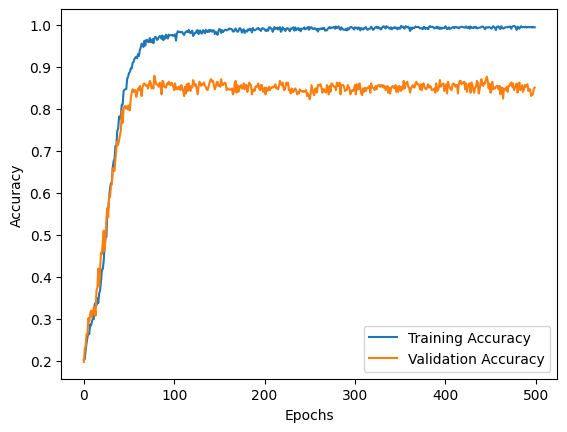

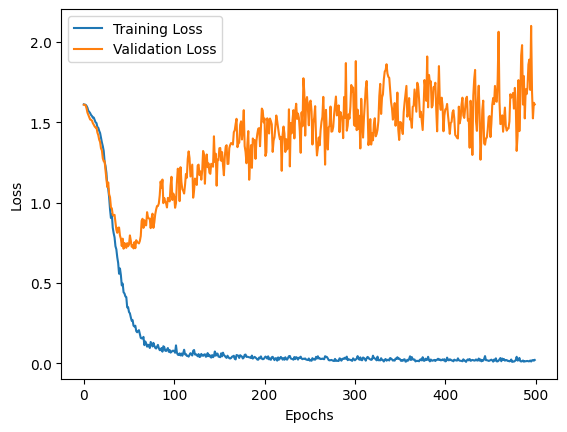

In [32]:
import matplotlib.pyplot as plt

history = model.history
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
model.evaluate(x=x_train, y=y_train)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9942 - loss: 0.0228


W0000 00:00:1735051572.505133      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.007441622205078602, 0.9973333477973938]

In [34]:
model.evaluate(x=x_test, y=y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8727 - loss: 1.3312


[1.6111199855804443, 0.8500000238418579]